In [1]:
opt = {
    outchan = 3,
    inchan = 3,
    num_frames = 3,
    num_epoch = 1000,
    batchsize = 128,
    valSize = 32,
    gpu = false
}

In [2]:
function string:split( inSplitPattern, outResults )
  if not outResults then
    outResults = { }
  end
  local theStart = 1
  local theSplitStart, theSplitEnd = string.find( self, inSplitPattern, 
theStart )
  while theSplitStart do
    table.insert( outResults, string.sub( self, theStart, theSplitStart-1 ) )
    theStart = theSplitEnd + 1
    theSplitStart, theSplitEnd = string.find( self, inSplitPattern, theStart )
  end
  table.insert( outResults, string.sub( self, theStart ) )
  return outResults
end

In [3]:
image = require 'image'
torch.setdefaulttensortype('torch.FloatTensor')

if opt.gpu then
    require 'cutorch'
    require 'cunn'
else
    inputdir = '/home/nicholas/Documents/small_faces/'
    truthdir = '/home/nicholas/Documents/big_faces/'
    inputvaldir = '/home/nicholas/Documents/small_val/'
    truthvaldir = '/home/nicholas/Documents/big_val/'
end

invidnames = {}
input_imgs = torch.FloatTensor()
label_imgs = torch.FloatTensor()
valimgs = torch.FloatTensor()
vallabels = torch.FloatTensor()

for file in paths.files('./') do
    if file:find('invidnames.t7' .. '$') then
        invidnames = torch.load('invidnames.t7')
    end
    if file:find('input_imgs.t7' .. '$') then
        input_imgs = torch.load('input_imgs.t7')
    end
    if file:find('label_imgs.t7' .. '$') then
        label_imgs = torch.load('label_imgs.t7')
    end
    if file:find('valvidnames.t7' .. '$') then
        valvidnames = torch.load('valvidnames.t7')
    end
    if file:find('valimgs.t7' .. '$') then
        valimgs = torch.load('valimgs.t7')
    end
    if file:find('vallabels.t7' .. '$') then
        vallabels = torch.load('vallabels.t7')
    end
end

if input_imgs:nDimension() == 0 then
    print('Loading all images from files')
    inputfiles = {}
    labelfiles = {}
    inputvalfiles = {}
    truthvalfiles = {}
    
    numTraining = 0
    numVal = 0
    
    for file in paths.files(inputdir) do
       if file:find('png' .. '$') then
        table.insert(inputfiles, paths.concat(inputdir,file))
        numTraining = numTraining + 1
       end
    end
    for file in paths.files(truthdir) do
       if file:find('png' .. '$') then
        table.insert(labelfiles, paths.concat(truthdir,file))
       end
    end
    for file in paths.files(inputvaldir) do
       if file:find('png' .. '$') then
        table.insert(inputvalfiles, paths.concat(inputvaldir,file))
        numVal = numVal + 1
       end
    end
    for file in paths.files(truthvaldir) do
       if file:find('png' .. '$') then
        table.insert(truthvalfiles, paths.concat(truthvaldir,file))
       end
    end


    -- Check files
    if #inputfiles == 0 or #labelfiles == 0 then
       error('given directory doesnt contain any files')
    end
    table.sort(inputfiles, function (a,b) return a < b end)
    table.sort(labelfiles, function (a,b) return a < b end)
    table.sort(inputvalfiles, function (a,b) return a < b end)
    table.sort(truthvalfiles, function (a,b) return a < b end)

    invidnames = {}
    input_imgs = torch.FloatTensor(numTraining, opt.inchan, 16, 16)
    label_imgs = torch.FloatTensor(numTraining, opt.outchan, 32, 32)

    for i,file in ipairs(inputfiles) do 
       input_imgs[i] = image.load(file)
       table.insert(invidnames, file:split('%.')[1])
    end

    for i,file in ipairs(labelfiles) do 
       label_imgs[i] = image.load(file)
    end

    -- construct validation set
    valvidnames = {}
    valimgs = torch.FloatTensor(numVal, opt.inchan, 16, 16)
    vallabels = torch.FloatTensor(numVal, opt.outchan, 32, 32)

    for i,file in ipairs(inputvalfiles) do 
       valimgs[i] = image.load(file)
       table.insert(valvidnames, file:split('%.')[1])
    end
    for i,file in ipairs(truthvalfiles) do 
       vallabels[i] = image.load(file)
    end

    torch.save('invidnames.t7', invidnames)
    torch.save('input_imgs.t7', input_imgs)
    torch.save('label_imgs.t7', label_imgs)
    torch.save('valvidnames.t7', valvidnames)
    torch.save('valimgs.t7', valimgs)
    torch.save('vallabels.t7', vallabels)
end

print('Images loaded')

Images loaded	


In [4]:
-- if not opt.gpu then
--     for i = 1,5 do
--        itorch.image(input_imgs[i])
--     end
--     for i = 1,5 do
--        itorch.image(label_imgs[i])
--     end
--     for i = 1,5 do
--        itorch.image(valimgs[i])
--     end
--     for i = 1,5 do
--        itorch.image(vallabels[i])
--     end
-- end
-- for i = 1,10 do
--    image.save(('validation/val_img_%d_input.png'):format(i), valimgs[i])
--    image.save(('validation/val_img_%d_label.png'):format(i), vallabels[i])
-- end

In [5]:
require 'nn'

-- input: inchan x 16 x 16
gen = nn.Sequential()

gen:add(nn.SpatialFullConvolution(opt.inchan * opt.num_frames, opt.outchan * 12, 3, 3))
gen:add(nn.ReLU(true))
-- gen:add(nn.SpatialBatchNormalization(opt.outchan * 2)):add(nn.ReLU(true))
-- -- size: opt.outchan * 8 x 18 x 18 

gen:add(nn.SpatialFullConvolution(opt.outchan * 12, opt.outchan * 6, 7, 7))
gen:add(nn.ReLU(true))
-- gen:add(nn.SpatialBatchNormalization(opt.outchan)):add(nn.ReLU(true))
-- size: opt.outchan * 4 x 24 x 24 

gen:add(nn.SpatialFullConvolution(opt.outchan * 6, opt.outchan, 9, 9))
gen:add(nn.ReLU(true))  
-- size: opt.outchan x 32 x 32

-- gen = nn.Sequential()

-- frames = nn.Parallel(2, 2)

-- upscale = nn.Sequential()
-- upscale:add(nn.SpatialFullConvolution(opt.inchan, opt.outchan * 8, 3, 3))
-- upscale:add(nn.ReLU(true))
-- -- upscale:add(nn.SpatialBatchNormalization(opt.outchan * 8)):add(nn.ReLU(true))
-- -- -- size: opt.outchan * 8 x 18 x 18 

-- upscale:add(nn.SpatialFullConvolution(opt.outchan * 8, opt.outchan * 4, 7, 7))
-- upscale:add(nn.ReLU(true))
-- -- upscale:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.ReLU(true))
-- -- size: opt.outchan * 4 x 24 x 24 

-- upscale:add(nn.SpatialFullConvolution(opt.outchan * 4, opt.outchan, 9, 9))
-- upscale:add(nn.ReLU(true))  
-- -- size: opt.outchan x 32 x 32

-- frames:add(upscale)
-- frames:add(upscale)
-- frames:add(upscale)

-- gen:add(frames)
-- gen:add(nn.SpatialConvolutionLocal(opt.outchan * opt.num_frames, opt.outchan, 32, 32, 1, 1))

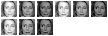

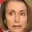

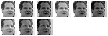

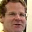

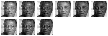

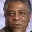

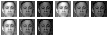

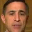

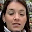

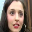

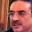

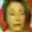

In [6]:
-- generate smaller validation set with previous and subsequent frames
valinputs = torch.FloatTensor(opt.valSize, opt.num_frames * opt.inchan, 16, 16)
-- valinputs = torch.FloatTensor(opt.valSize, opt.num_frames, opt.inchan, 16, 16)
valtruths = torch.FloatTensor(opt.valSize, opt.inchan, 32, 32)

for vi = 1, opt.valSize do
    local rand_id = torch.random(2, valimgs:size(1) - 1)
--     while not (valvidnames[rand_id]:split(1)[1] == valvidnames[rand_id - 1]:split(1)[1] and valvidnames[rand_id]:split(1)[1] == valvidnames[rand_id + 1]:split(1)[1]) do
    while not (valvidnames[rand_id] == valvidnames[rand_id - 1] and valvidnames[rand_id] == valvidnames[rand_id + 1]) do
        rand_id = torch.random(2, valimgs:size(1) - 1)
    end
    valinputs[vi] = torch.cat(valimgs[rand_id - 1], valimgs[rand_id], 1):cat(valimgs[rand_id + 1], 1)
--     valinputs[{vi, 1, {}, {}, {}}] = valimgs[rand_id - 1]
--     valinputs[{vi, 2, {}, {}, {}}] = valimgs[rand_id]
--     valinputs[{vi, 3, {}, {}, {}}] = valimgs[rand_id + 1]
    valtruths[vi] = vallabels[rand_id]
end

-- testing validation on actual training images (bad in practice, just testing)
-- for vi = 1, opt.valSize do
--     local rand_id = torch.random(2, input_imgs:size(1) - 1)
--     while not (invidnames[rand_id]:split(1)[1] == invidnames[rand_id - 1]:split(1)[1] and invidnames[rand_id]:split(1)[1] == invidnames[rand_id + 1]:split(1)[1]) do
--         rand_id = torch.random(2, input_imgs:size(1) - 1)
--     end
--     valinputs[vi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
--     valtruths[vi] = label_imgs[rand_id]
-- end
if not opt.gpu then
    for vi = 1, 4 do
        itorch.image(valinputs[vi])
        itorch.image(valtruths[vi])
    end
end


-- test construct batch
inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
-- inputs = torch.FloatTensor(opt.batchsize, opt.num_frames, opt.inchan, 16, 16)
labels = torch.FloatTensor(opt.batchsize, opt.outchan, 32, 32)

for bi = 1, opt.batchsize do
    local rand_id = torch.random(2, input_imgs:size(1) - 1)
    while not(invidnames[rand_id] == invidnames[rand_id - 1] and invidnames[rand_id] == invidnames[rand_id + 1]) do
--     while not(invidnames[rand_id]:split(1)[1] == invidnames[rand_id - 1]:split(1)[1] and invidnames[rand_id]:split(1)[1] == invidnames[rand_id + 1]:split(1)[1]) do
--         print(invidnames[rand_id - 1])
--         print(invidnames[rand_id])
--         print(invidnames[rand_id + 1])
        rand_id = torch.random(2, input_imgs:size(1) - 1)
    end  
    inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
--     inputs[{bi, 1, {}, {}, {}}] = input_imgs[rand_id - 1]
--     inputs[{bi, 2, {}, {}, {}}] = input_imgs[rand_id]
--     inputs[{bi, 3, {}, {}, {}}] = input_imgs[rand_id + 1]
    labels[bi] = label_imgs[rand_id]
end
if not opt.gpu then
    for bi = 1, 4 do
        itorch.image(inputs[{bi, {4,6}, {}, {}}])
--         itorch.image(inputs[bi])
        itorch.image(labels[bi])
    end
end

if opt.gpu then
    input_imgs = input_imgs:cuda()
    label_imgs = label_imgs:cuda()
    valimgs = valimgs:cuda()
    vallabels = vallabels:cuda()
    valinputs = valinputs:cuda()
    valtruths = valtruths:cuda()
    gen = gen:cuda()
end

In [ ]:
require 'optim'

criterion = nn.AbsCriterion()
if opt.gpu then
    criterion:cuda()
end
local optimState = {learningRate = 0.0001}

epoch_tm = torch.Timer()
total_tm = torch.Timer()
for epoch = 1, opt.num_epoch do
    
    -- construct batch
    inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
--     inputs = torch.FloatTensor(opt.batchsize, opt.num_frames, opt.inchan, 16, 16)
    labels = torch.FloatTensor(opt.batchsize, opt.outchan, 32, 32)
    if opt.gpu then
        inputs = inputs:cuda()
        labels = labels:cuda()
    end

    for bi = 1, opt.batchsize do
        local rand_id = torch.random(2, input_imgs:size(1) - 1)
        while not(invidnames[rand_id] == invidnames[rand_id - 1] and invidnames[rand_id] == invidnames[rand_id + 1]) do
--         while not(invidnames[rand_id]:split(1)[1] == invidnames[rand_id - 1]:split(1)[1] and invidnames[rand_id]:split(1)[1] == invidnames[rand_id + 1]:split(1)[1]) do
            rand_id = torch.random(2, input_imgs:size(1) - 1)
        end  
        inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
--         inputs[{bi, 1, {}, {}, {}}] = input_imgs[rand_id - 1]
--         inputs[{bi, 2, {}, {}, {}}] = input_imgs[rand_id]
--         inputs[{bi, 3, {}, {}, {}}] = input_imgs[rand_id + 1]
        labels[bi] = label_imgs[rand_id]
    end
    
    params, gradParams = gen:getParameters()
    
    -- evaluation, forwards/backward pass
    fGx = function(params)
        gradParams:zero()
        outputs = gen:forward(inputs)

        errG = criterion:forward(outputs, labels)
        df_do = criterion:backward(outputs, labels)
--         df_dg = disc:updateGradInput(inputs, df_do) -- when discriminator is implemented
        gen:backward(inputs, df_do)
        return errG, gradParams
    end
    
    -- train
    optim.adam(fGx, params, optimState)
    
    -- validate
    if epoch % 200 == 0 then
        outputs = gen:forward(valinputs)
        if not opt.gpu then
            for vi = 1, 4 do
--                 itorch.image(valinputs[{vi, 2, {}, {}}])
                itorch.image(valinputs[vi])
                itorch.image(outputs[vi])
--                 itorch.image(image.scale(valinputs[{vi, 2, {}, {}}], 64, 64, 'simple'))
                itorch.image(image.scale(valinputs[vi], 64, 64, 'simple'))
                itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
            end
        end
        valerr = criterion:forward(outputs, valtruths)
        print(('\nvalidation error at epoch = %d is %.4f \t Time Taken: %.3f'):format(epoch, valerr, epoch_tm:time().real))
        
        epoch_tm:reset()
    end
    gen:clearState()
end
print(('\n total time taken: %.3f'):format(total_tm:time().real))
gen:float()
torch.save('srez_model_local.t7', gen)